In [1]:
# Import Python modules
import os, sys
import yaml
import numpy as np
import pandas as  pd
import xarray as xr
from datetime import timedelta, date
import textwrap

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# Path to modules
sys.path.append('../../modules')

# Import my modules
from plotter import draw_basemap
from ar_funcs import get_ar_days, duration_stats
from constants import ucsd_colors

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths
server = "skyriver"
if server == "comet":
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
elif server == "skyriver":
    path_to_data = '/work/dnash/data/'
path_to_out  = '../../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../../figs/'      # figures

In [3]:
# label strings
ivt_units = 'kg m$^{-1}$ s$^{-1}$'

# Select lat/lon grid
bnds = [360-168., 360-129., 50., 75.] # extend of AK
ext1 = [-168, -129.0, 50., 75] # extent of AK
# bnds = [360-141., 360-130., 54., 61.] # extent of SEAK
# ext1 = [-141.5, -130.0, 54., 61.5] # extent of SEAK
lonmin, lonmax, latmin, latmax = bnds

# set start and end dates to match WRF data
start_date = '1980-01-01 0:00'
end_date = '2019-12-31 23:00'

In [4]:
%%time
ar_filename =  '/home/dnash/comet_data/downloads/AR_Catalog/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ds = xr.open_dataset(ar_filename)
# ds = ds.assign_coords(lon=(((ds.lon + 180) % 360)-180))
# ds
da = ds.sel(time=slice(start_date, end_date), lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
da

CPU times: user 334 ms, sys: 62.9 ms, total: 397 ms
Wall time: 521 ms


<xarray.Dataset>
Dimensions:      (lon: 27, lat: 17, lev: 1, time: 57952, ens: 1)
Coordinates:
  * lon          (lon) float64 192.0 193.5 195.0 196.5 ... 228.0 229.5 231.0
  * lat          (lat) float64 51.0 52.5 54.0 55.5 57.0 ... 70.5 72.0 73.5 75.0
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1980-01-01 ... 2019-08-31T18:00:00
  * ens          (ens) float64 1.0
Data variables: (12/53)
    islnd        (lat, lon) float32 ...
    iscst        (lat, lon) float32 ...
    shapemap     (ens, time, lev, lat, lon) float32 ...
    axismap      (ens, time, lev, lat, lon) float64 ...
    tnsctmap     (ens, time, lev, lat, lon) float64 ...
    lflocmap     (ens, time, lev, lat, lon) float32 ...
    ...           ...
    axisidx      (ens, time, lev, lat, lon) float32 ...
    axislon      (ens, time, lev, lat, lon) float32 ...
    axislat      (ens, time, lev, lat, lon) float32 ...
    xtnsctidx    (ens, time, lev, lat, lon) float32 ...
    numobj       (ens, time, lev, lat, lon) float32 ...
    intblosto    (ens, lev, lat, lon) float64 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2022.03.22
    creation_date:         22-Mar-2022 11:12:14
    tARget_version:        1.300
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

In [5]:
## Option 1: AR days based on if they make "landfall" in SE AK
# option = 'landfall'

## Option 2: AR days based on if the AR is within SEAK bounding box
option = 'bounding-box'


In [6]:
lfloc = da.lflocmap.squeeze()
lfloc_ct = lfloc.count('time')
clim_freq = lfloc_ct.squeeze().values

index_clim = np.flatnonzero(clim_freq)
print(index_clim.shape)
landfall_clim = clim_freq.ravel()[index_clim]
print(landfall_clim.shape)

clim_lons, clim_lats = np.meshgrid(lfloc_ct.lon, lfloc_ct.lat)
clim_lat_list = clim_lats.ravel()[index_clim]
print(clim_lat_list.shape)
clim_lon_list = clim_lons.ravel()[index_clim]
print(clim_lon_list.shape)


(44,)
(44,)
(44,)
(44,)


In [7]:
da.lat.values[:100]

array([51. , 52.5, 54. , 55.5, 57. , 58.5, 60. , 61.5, 63. , 64.5, 66. ,
       67.5, 69. , 70.5, 72. , 73.5, 75. ])

In [8]:
da.lon.values[:100]

array([192. , 193.5, 195. , 196.5, 198. , 199.5, 201. , 202.5, 204. ,
       205.5, 207. , 208.5, 210. , 211.5, 213. , 214.5, 216. , 217.5,
       219. , 220.5, 222. , 223.5, 225. , 226.5, 228. , 229.5, 231. ])

In [9]:
## manually adding points to land mask
lats_add = [58.5, 58.5, 57., 57., 55.5, 55.5, 54, 54, 55.5, 55.5, 55.5, 55.5, 57., 57, 57, 58.5]
lons_add = [-139.5, -138.0, -136.5, -135., -135., -133.5, -166.5, -165, -163.5, -162, -160.5, -159, -159, -154.5, -153, -153]

for i, (xs1, ys1) in enumerate(zip(lons_add, lats_add)):
    da.islnd.loc[dict(lat=ys1, lon=xs1+360.)] = 1

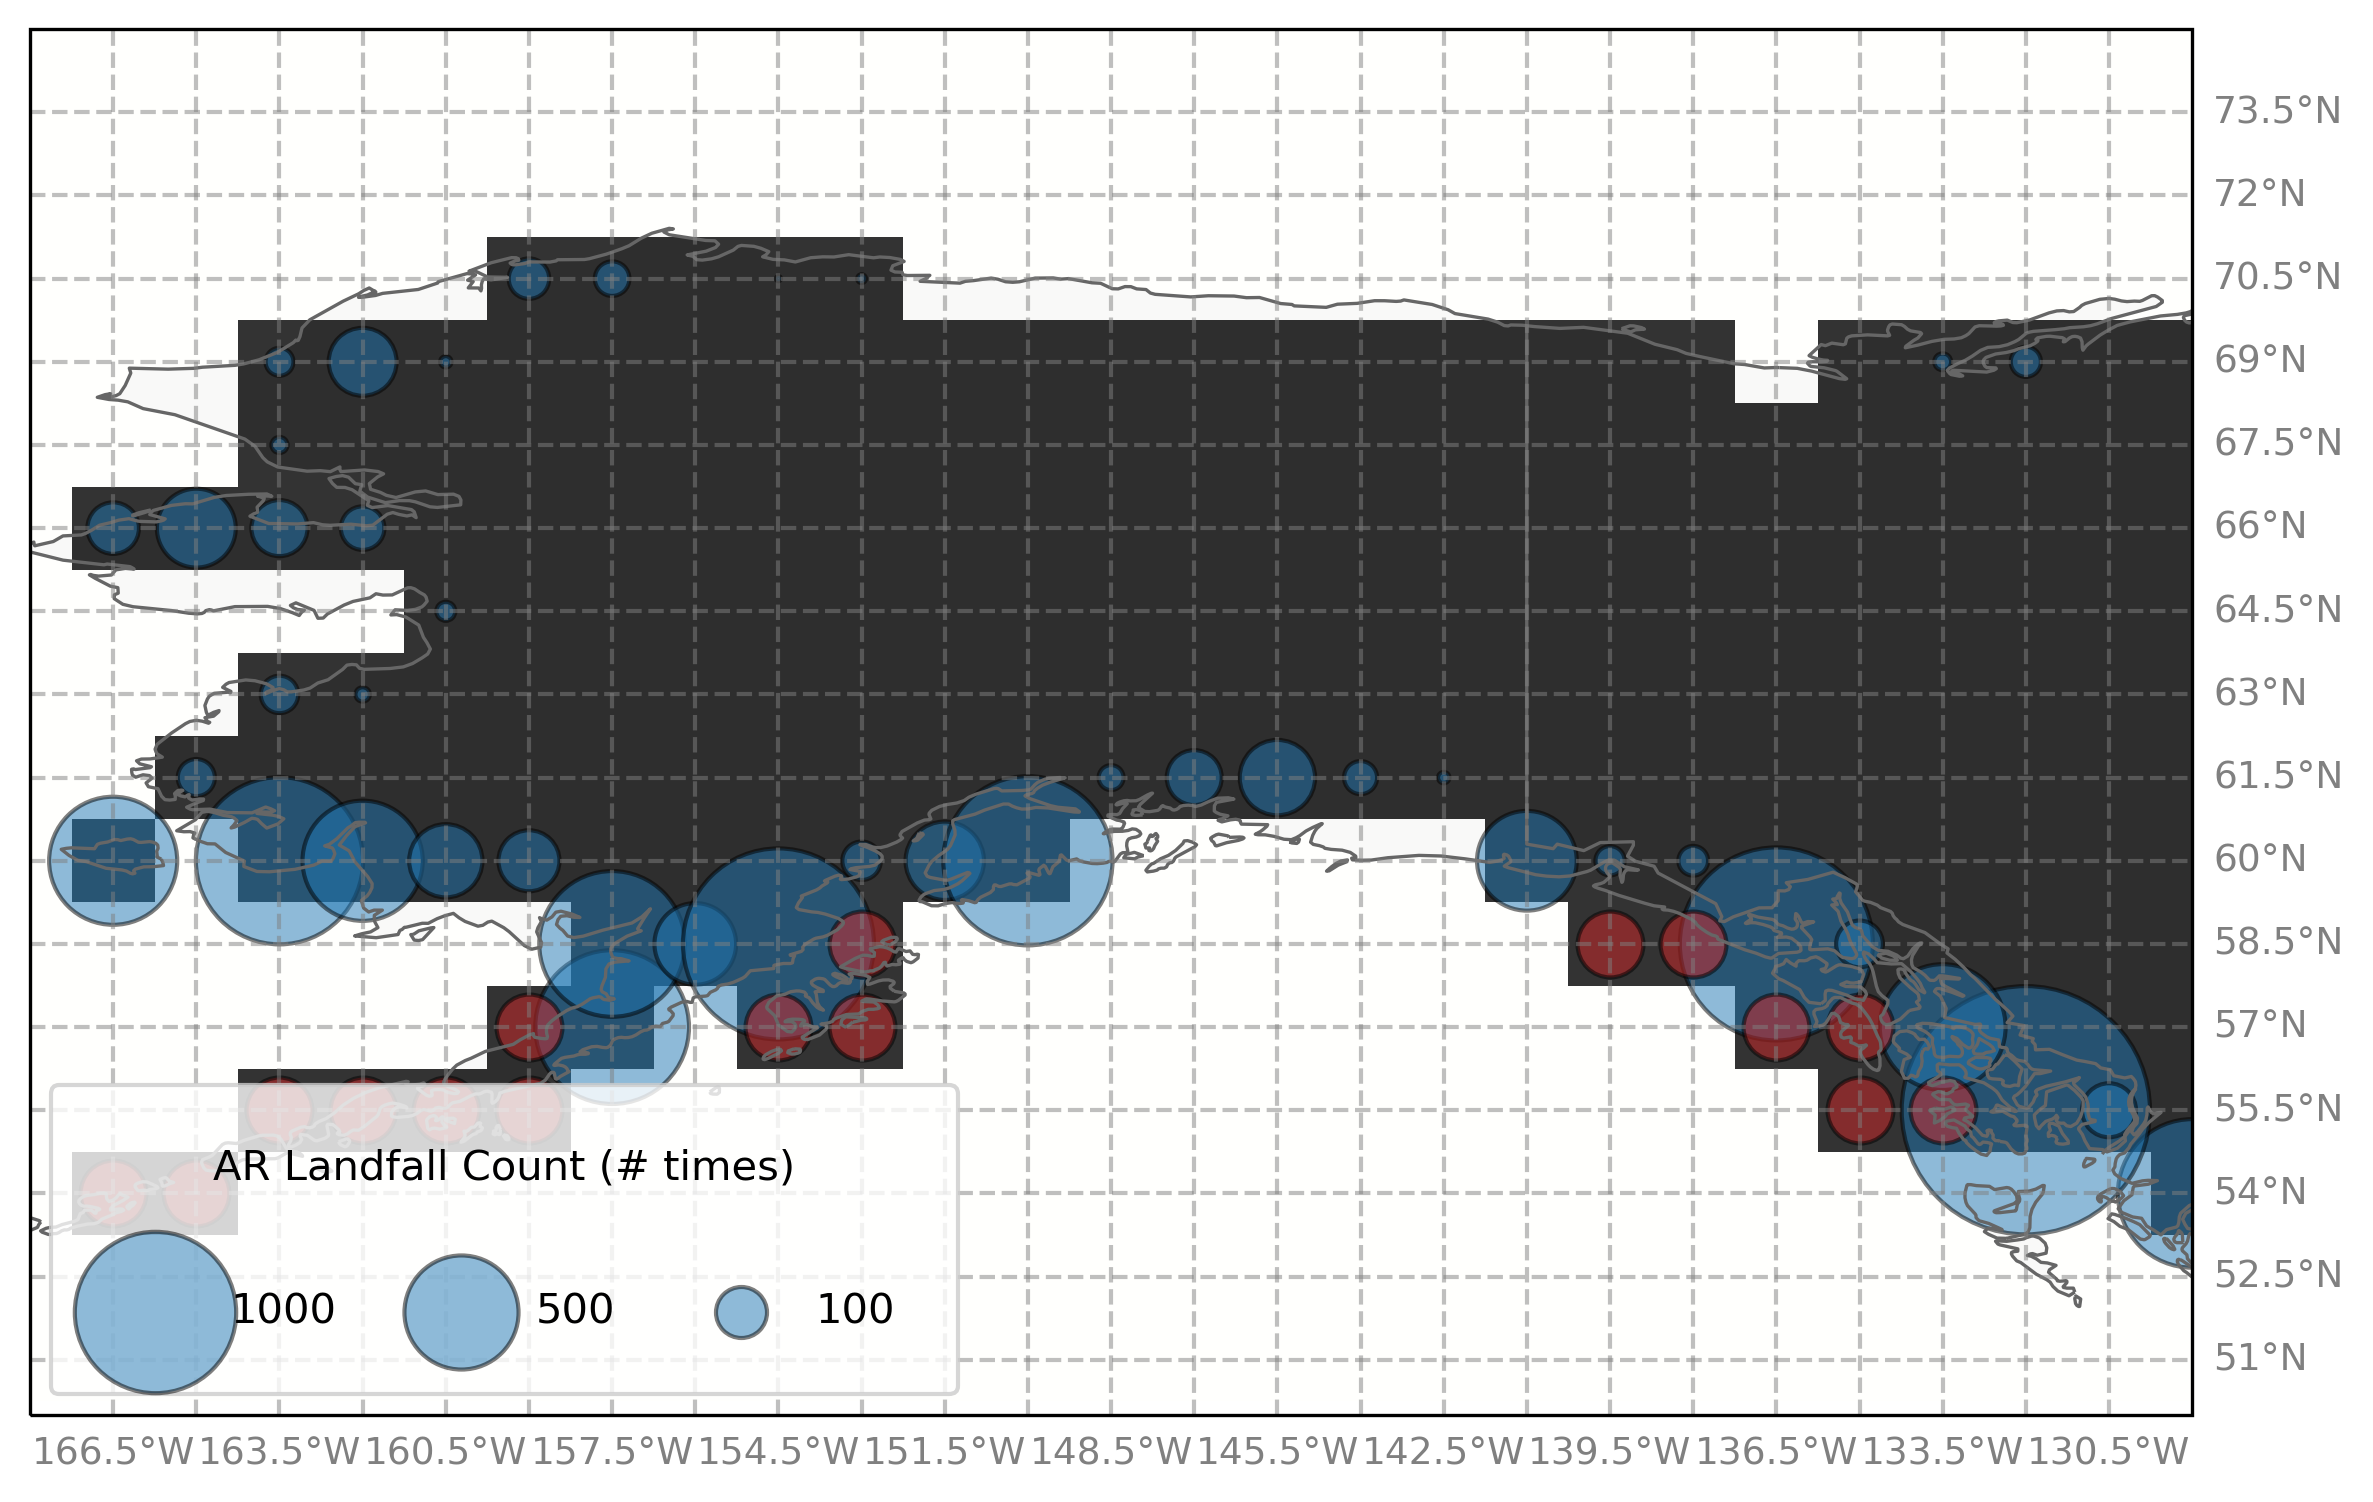

In [10]:
fname = path_to_figs + 'ar-landfall_freq'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((12.,6.))
fig.dpi = 300

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
xticks = np.arange(da.lat.min(),da.lat.max()+1.5,1.5)
yticks = np.arange(da.lon.min()-360.,da.lon.max()-360.+1.5,1.5)
    
ax = plt.axes(projection=mapcrs)
ax.set_extent(ext1, crs=datacrs)

# Add map features (continents and country borders)
ax.add_feature(cfeature.LAND, facecolor='0.9')      
ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)

## add land mask
land = da.islnd
cs = ax.pcolormesh(land.lon, land.lat, land.values, transform=datacrs,
                 cmap=cmo.gray_r, alpha=0.8)

## Add ERA-Interim Gridlines and Labels
gl = ax.gridlines(crs=datacrs, draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(yticks)
gl.ylocator = mticker.FixedLocator(xticks)
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabel_style = {'size': 9, 'color': 'gray'}
gl.ylabel_style = {'size': 9, 'color': 'gray'}

# Bubbles
x = clim_lon_list
y = clim_lat_list 
z = landfall_clim
scl = 1.5
sc = ax.scatter(x, y, s=z*scl, c='tab:blue', marker='o', alpha=0.5, transform=mapcrs, edgecolors='k')
new = ax.scatter(lons_add, lats_add, s=250, c='tab:red', marker='o', alpha=0.5, transform=mapcrs, edgecolors='k')

# legend
    
msizes = [1000*scl, 500*scl, 100*scl]
markers = []
for size in msizes:
    markers.append(plt.scatter([],[], s=size, c='tab:blue', edgecolors='k', label=(int(size/scl)), alpha=0.5))

ax.legend(handles=markers, loc='lower left', labelspacing=2.5, borderpad=1.5, title='AR Landfall Count (# times)', ncol=3)


# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
plt.show()

In [11]:
lfdates = lfloc.where(lfloc > 0, drop=True).time.values # only pulls the dates where an AR made landfall in SE AK
print('No. of AR landfalls in SE AK:', len(lfdates))

kidmap = da.kidmap.squeeze()
kidmap = kidmap.where(da.islnd == 1) # mask kidmap where is ocean
ardates = kidmap.where(kidmap > 0, drop=True).time.values # pulls the dates when an AR object is within bbox 
print('No. of AR objects near SE AK:', len(ardates))

No. of AR landfalls in SE AK: 14582
No. of AR objects near SE AK: 26957


In [12]:
# create list of lists of trackIDs for each time step
if option == 'landfall':
    date_lst = lfdates
elif option == 'bounding-box':
    date_lst = ardates
final_lst = []
for i, ids in enumerate(date_lst):
#     print(ids)
    # pull track ID list for each time step
    x = kidmap.sel(time=ids).values.flatten()
    result = x[np.logical_not(np.isnan(x))]
    trackID = np.unique(result)
    # # get landfalling latitude and longitude
    # tmp = lfloc.sel(time=ids)
    # tmp = tmp.where(tmp > 0, drop=True)
    # lflat = tmp.lat.values
    # lflon = tmp.lon.values - 360.0 # to get degrees W value

    for j in range(len(trackID)):
        final_lst.append([ids, trackID[j]])
    
# put final_lst into df
track_df = pd.DataFrame(final_lst, columns=['date', 'trackID'])
track_df
track_ids = track_df.trackID.unique()
# create df with trackID, start date, end date, and duration of AR
data = []
for i, ids in enumerate(track_ids):
    idx = (track_df.trackID == ids)
    test = track_df.loc[idx]
    start = test.date.min()
    stop = test.date.max() + timedelta(hours=6)
    tmp = (stop-start)
    duration = tmp.total_seconds()/(3600) # convert to number of hours
    
    data.append([ids, start, stop, duration])
    
duration_df = pd.DataFrame(data, columns=['trackID', 'start_date', 'end_date', 'duration'])
duration_df

,trackID,start_date,end_date,duration
0,1.980010e+11,1980-01-04 00:00:00,1980-01-06 06:00:00,54.0
1,1.980011e+11,1980-01-17 06:00:00,1980-01-19 18:00:00,60.0
2,1.980012e+11,1980-01-18 06:00:00,1980-01-18 12:00:00,6.0
3,1.980012e+11,1980-01-19 18:00:00,1980-01-20 06:00:00,12.0
4,1.980012e+11,1980-01-20 12:00:00,1980-01-23 06:00:00,66.0
...,...,...,...,...
6063,2.019082e+11,2019-08-22 18:00:00,2019-08-23 00:00:00,6.0
6064,2.019082e+11,2019-08-23 12:00:00,2019-08-24 06:00:00,18.0
6065,2.019083e+11,2019-08-26 00:00:00,2019-08-26 06:00:00,6.0
6066,2.019083e+11,2019-08-26 18:00:00,2019-08-27 06:00:00,12.0


In [13]:
## save to csv
outfile = path_to_out + 'AR_track_duration_AK.csv'
duration_df.to_csv(outfile)

### Get simple list of datetimes an AR is present

In [24]:
def get_ar_dates_from_duration_df(duration_df, freq):
    # Get list of AR time steps from the start-stop dates
    dt_lst = []
    for index, row in duration_df.iterrows():
        dt = pd.date_range(row['start_date'], row['end_date'], freq='1H')
        dt_lst.append(dt)
        
    ardates = dt_lst[0].union_many(dt_lst[1:])
    # put into dataframe
    d = {'ar_dates': ardates}
    df = pd.DataFrame(data=d)

    # keep only unique dates
    df.index = pd.to_datetime(df.ar_dates)
    df_new = df.ar_dates.unique()
    d = {'ar_dates': df_new}
    df = pd.DataFrame(data=d)
    
    if freq == '1D':
        ## this method takes the hourly dataset and converts it to daily
        df_hourly = df
        df_hourly.index = pd.to_datetime(df_hourly.ar_dates)
        idx = (df_hourly.index.hour == 0) | (df_hourly.index.hour == 6) | (df_hourly.index.hour == 12) | (df_hourly.index.hour == 18)
        test_daily = df_hourly.loc[idx]
        test_daily.index = test_daily.ar_dates.dt.normalize()
        df_new = test_daily.index.unique()
        d = {'ar_dates': df_new}
        df_daily = pd.DataFrame(data=d)
        df = df_daily
    else:
        df = df
        
    ## clean up dataframe to have 1's where AR == True
    df.index = pd.to_datetime(df.ar_dates)
    df = df.drop(['ar_dates'], axis=1)
    df = df.reset_index()
    df = df.rename(columns={"ar_dates": "dates"})
    df['ar'] = 1

    # date array with all days
    dates_allDays = pd.date_range(start=start_date, end=end_date, freq=freq)
    arr_allDays = np.zeros(len(dates_allDays), dtype=int)

    # Loop over ar days and match to ar_full 
    for i, date in enumerate(df['dates'].values):
        idx = np.where(dates_allDays == date)
        arr_allDays[idx] = 1

    # Create dataframe
    data = {'AR':arr_allDays}
    df_all = pd.DataFrame(data, index=dates_allDays)
    
    return df_all

In [25]:
ardates_hourly = get_ar_dates_from_duration_df(duration_df, '1H')
ardates_daily = get_ar_dates_from_duration_df(duration_df, '1D')



/tmp/ipykernel_4057866/1502782575.py:8: FutureWarning: DatetimeIndex.union_many is deprecated and will be removed in a future version. Use obj.union instead.
  ardates = dt_lst[0].union_many(dt_lst[1:])
/tmp/ipykernel_4057866/1502782575.py:8: FutureWarning: DatetimeIndex.union_many is deprecated and will be removed in a future version. Use obj.union instead.
  ardates = dt_lst[0].union_many(dt_lst[1:])


In [ ]:
## save to csv file
ardates_hourly.to_csv(path_to_out + 'AK_ardates_hourly.csv')
ardates_daily.to_csv(path_to_out + 'AK_ardates_daily.csv')